# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Full description of ARIMA

<br></font>
</div>

# What is the ARIMA model?

<div class="alert alert-block alert-info">
<font color=black><br>

- It is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values. However, you’ll have to use your own judgment if that makes sense at all!
- It is a generalization of the simpler AutoRegressive Moving Average:
    - **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations. A pure Auto Regressive (AR only) model is one where a value depends only on its own lags.
    - **I**: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary. 
    - **MA**: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations. A pure Moving Average (MA only) model is one where Yt depends only on the lagged forecast errors.
- So what does ARIMA model do? An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. 

<br></font>
</div>

# Import modules

In [1]:
from statsmodels.tsa.stattools import adfuller, acf
from numpy import log
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Import dataset

In [2]:
df = pd.read_csv('../../DATASETS/wwwusage.csv', names=['value'], header=0)

In [3]:
df

,value
0,88
1,84
2,85
3,85
4,84
...,...
95,222
96,228
97,226
98,222


<AxesSubplot:>

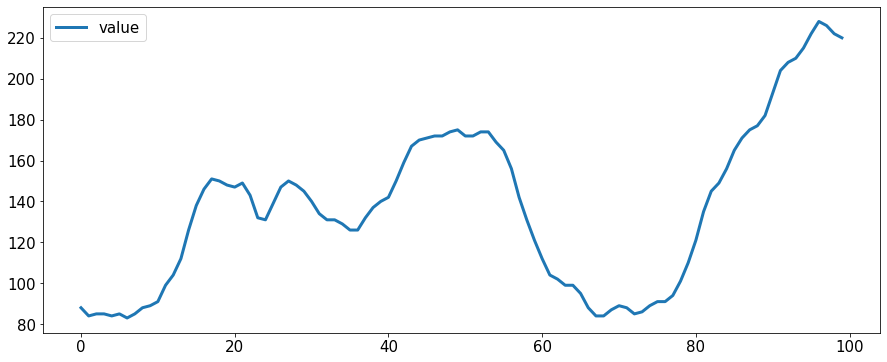

In [4]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 15
df.plot(lw = 3)

# Is stationary?

<div class="alert alert-block alert-info">
<font color=black><br>

- We'll use the **Augmented Dickey Fuller test** to check if the series is stationary.
- The **null hypothesis** of the ADF test is that the time series is non-stationary.
- Since P-value is greater than the significance level the series is **non-stationary**.

<br></font>
</div>

In [5]:
result = adfuller(df.value.dropna())
print('ADF Statistic [significance level]: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic [significance level]: -2.464240
p-value: 0.124419


# Order of differecing?

<div class="alert alert-block alert-info">
<font color=black><br>

- The right order of differencing is the **minimum** differencing required to get a **near-stationary** series which **roams around** a defined mean and the ACF plot reaches to zero **fairly quick**.
    - If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. 
    - If the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.
- If undecided, then go with the order that gives the least standard deviation in the differenced series.

<br></font>
</div>

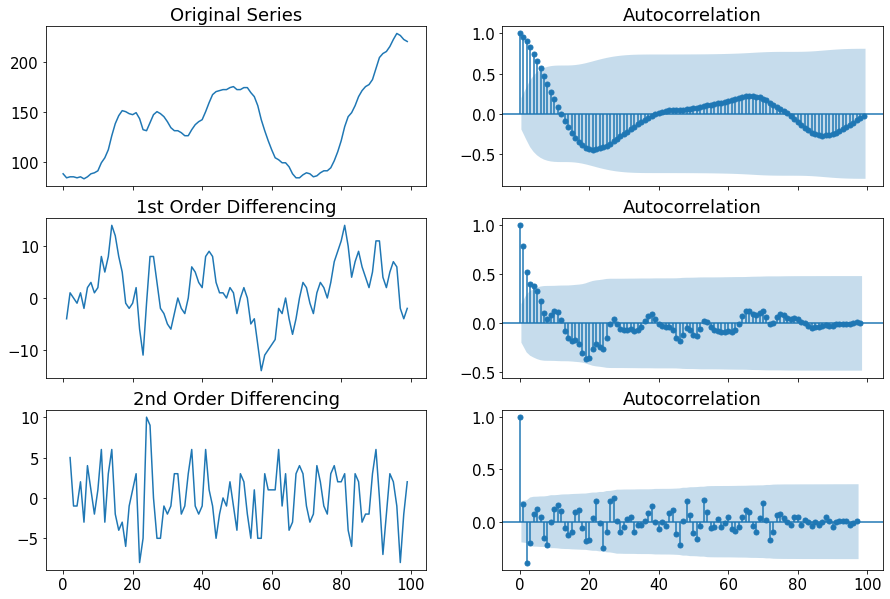

In [6]:
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 15

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); 
axes[0, 0].set_title('Original Series')
plot_acf(df.value, lags=len(df.value)-1, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), lags=len(df.value.diff().dropna())-1, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), lags=len(df.value.diff().diff().dropna())-1, ax=axes[2, 1])

plt.show()

<div class="alert alert-block alert-info">
<font color=black><br>

- The time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the **far negative zone fairly quick**, which indicates, the series might have been **over differenced**.
- **What do we do about it?** We'll settle for a differencing as 1 which gives a **weak stationarity**.

<br></font>
</div>

# Lag order p?

<div class="alert alert-block alert-info">
<font color=black><br>

- **p** is the number of lag observations included in the model, also called the lag order.  
- You can find out the p value by inspecting the **Partial Autocorrelation** (PACF) plot.
- **Partial autocorrelation** can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

<br></font>
</div>

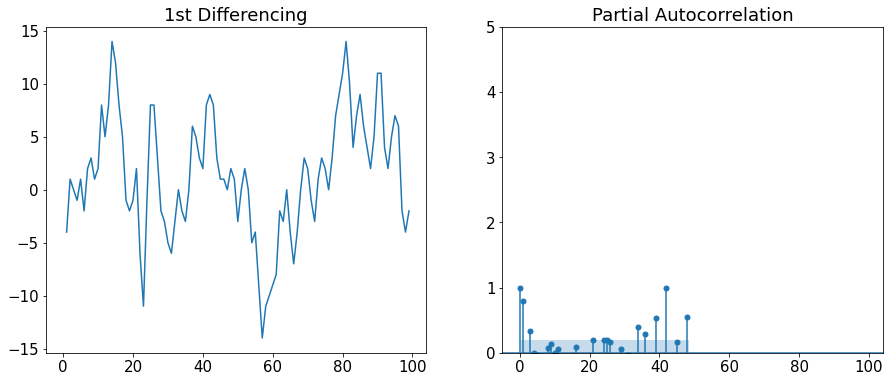

In [7]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 15

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); 
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
# Can only compute partial correlations for lags up to 50% of the sample size
plot_pacf(df.value.diff().dropna(), lags = len(df.value.diff().dropna())*0.5-1, ax=axes[1])

plt.show()

<div class="alert alert-block alert-info">
<font color=black><br>

- The blue area is the significance limit.
- The lag = 1 in the PACF is quite significant since is well above the blue region.
- The lag = 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region).
- We'll still use p =1, just to be conservative.

<br></font>
</div>

# Moving average window q?

<div class="alert alert-block alert-info">
<font color=black><br>

- **q**: is the size of the moving average window, also called the order of moving average.
- Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.
- The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

<br></font>
</div>

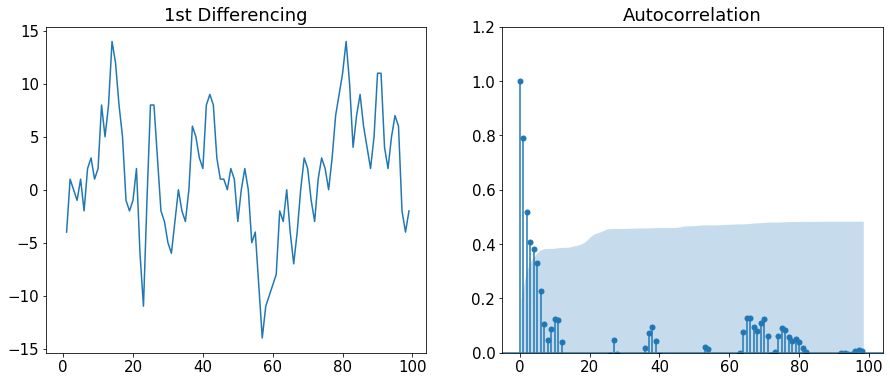

In [8]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), lags=len(df.value.diff().dropna())-1, ax=axes[1])

plt.show()

<div class="alert alert-block alert-info">
<font color=black><br>

- Couple of lags are well above the significance line. 
- So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

<br></font>
</div>

# Build the ARIMA model

In [9]:
# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Mon, 25 Oct 2021   AIC                            517.579
Time:                        08:39:40   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.385      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.014       0.131       1.139
ma.L1.D.value     0.5287      0.355     

<div class="alert alert-block alert-info">
<font color=black><br>

- Notice here the coefficient of the **ma.L2** term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. 
- It should ideally be less than 0.05 for the respective X to be significant.
- So, let’s rebuild the model without the MA2 term. 

<br></font>
</div>

In [10]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Mon, 25 Oct 2021   AIC                            515.579
Time:                        08:39:40   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

<div class="alert alert-block alert-info">
<font color=black><br>

- The model AIC has reduced, which is good. 
- The P Values of the AR1 and MA1 terms have improved and are **highly significant** (<< 0.05).
- Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance). 

<br></font>
</div>

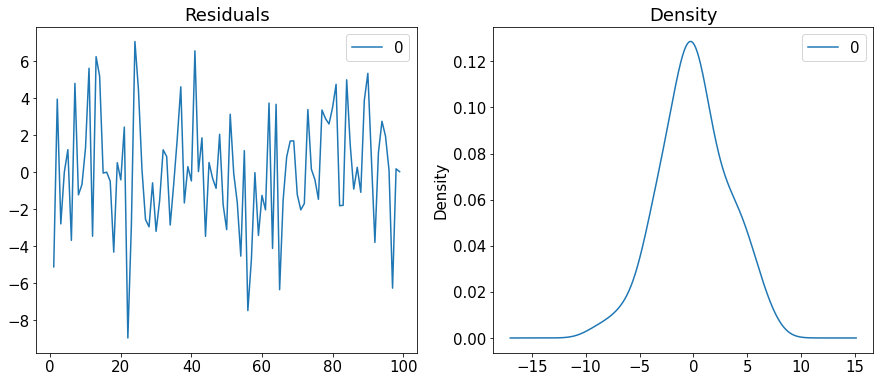

In [11]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 15

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Original vs. forecast

<div class="alert alert-block alert-info">
<font color=black><br>

- **dynamic=False** then in-sample lagged values are used for prediction.
- That is, the model gets trained up until the previous value to make the next prediction. 
- This can make the fitted forecast and actuals look artificially good.

<br></font>
</div>

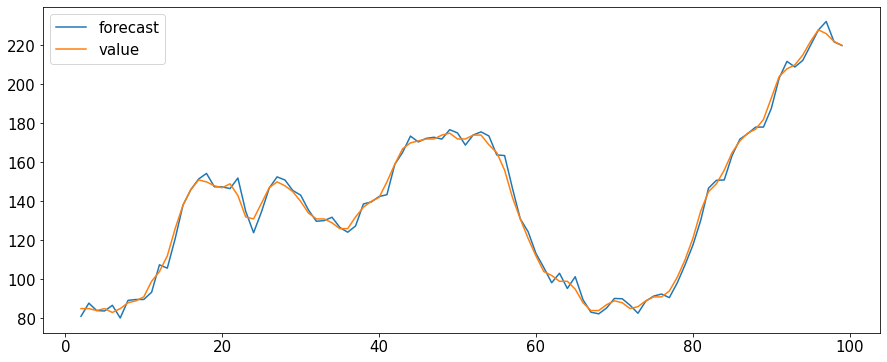

In [12]:
model_fit.plot_predict(dynamic=False)
plt.show()

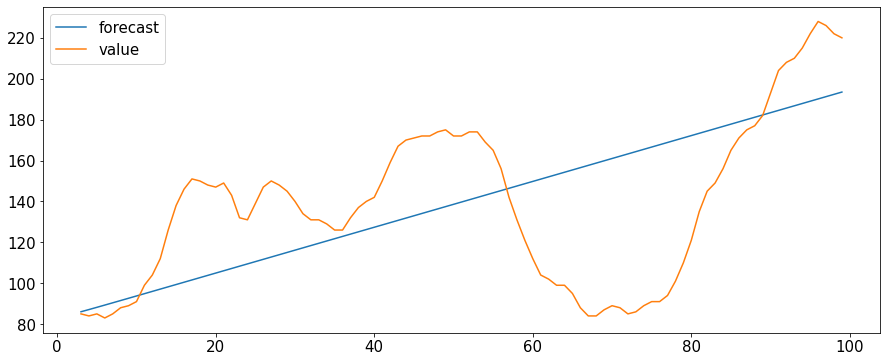

In [13]:
model_fit.plot_predict(dynamic=True)
plt.show()

<div class="alert alert-block alert-info">
<font color=black><br>

- **Is this a good model?** Can’t say that at this point because we haven’t actually forecasted into the future.
- So, the real validation you need now is the **Out-of-Time** cross-validation.
- is out-of-time = Out-of-sample?

<br></font>
</div>

# Out-of-Time Cross validation

<div class="alert alert-block alert-info">
<font color=black><br>

- In Out-of-Time cross-validation, you take few steps back in time and forecast into the future.
- To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio.
- You should *not** reshuffle the data as the order in time is important.
- If we split at 85, we are going to predict the next **15** points.

<br></font>
</div>

In [14]:
train = df.value[:85]
test = df.value[85:]

In [15]:
model = ARIMA(train, order = (1, 1, 1))  
fitted = model.fit(disp = -1) 

In [16]:
# Forecast with a 95% confidence band
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

In [17]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

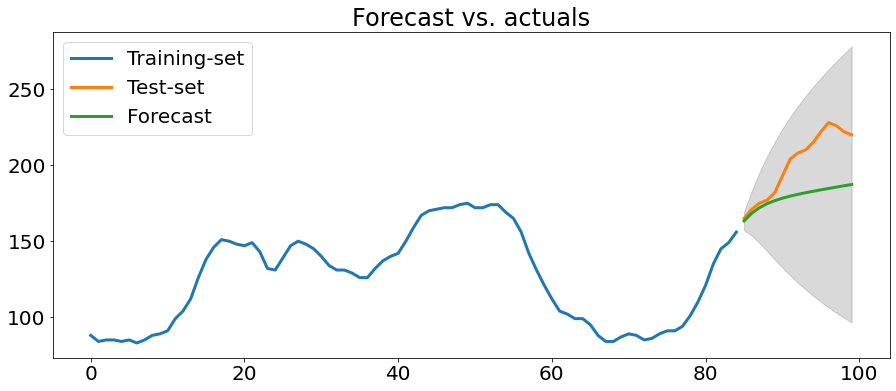

In [18]:
# Plot
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 20

plt.figure()
plt.plot(train, lw = 3, label = 'Training-set')
plt.plot(test, lw = 3, label = 'Test-set')
plt.plot(fc_series, lw = 3, label = 'Forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs. actuals')
plt.legend(loc='upper left')
plt.show()

# Modeling tuning

<div class="alert alert-block alert-info">
<font color=black><br>

- The model seems to give a directionally correct forecast with forecasted values lieing within the 95% confidence band.
- **However**, each of the predicted forecasts is **consistently below** the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve.
- So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.
- Here we we stopped at (3,2,1) as model perform already pretty well.
- While doing this, the p-values of the AR and MA should be as close to zero, **ideally, less than 0.05**.

<br></font>
</div>

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Mon, 25 Oct 2021   AIC                            440.497
Time:                        08:39:42   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.564      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

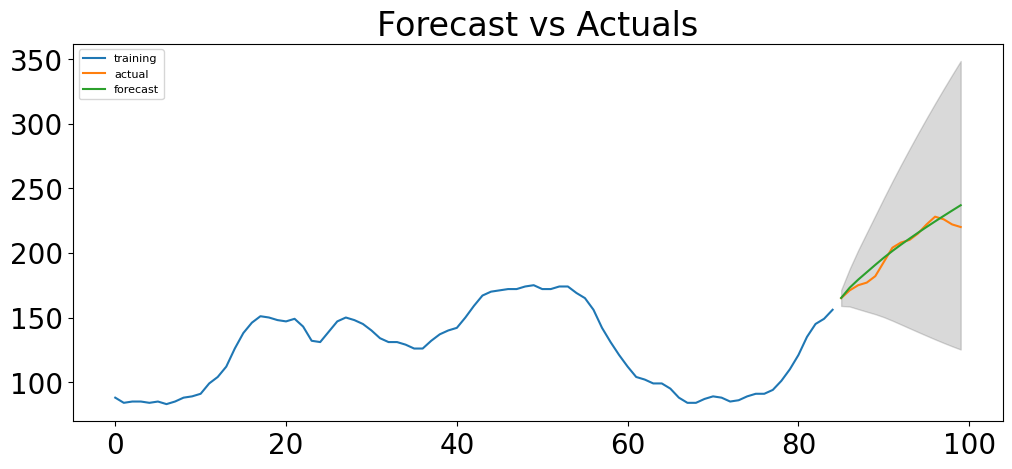

In [19]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Model accuracy

<div class="alert alert-block alert-info">
<font color=black><br>

- Forecast metrics are:
    - Mean Absolute Percentage Error (MAPE)
    - Mean Error (ME)
    - Mean Absolute Error (MAE)
    - Mean Percentage Error (MPE)
    - Root Mean Squared Error (RMSE)
    - Lag 1 Autocorrelation of Error (ACF1)
    - Correlation between the Actual and the Forecast (corr)
    - Min-Max Error (minmax)
- Generally **only** MAPE, correlationa nd Min-Max error are used becasuse they are expressed in percentage, thus can be used to compare forecast of two different scale in time.

<br></font>
</div>

In [20]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [21]:
forecast_accuracy(fc, test.values)

{'mape': 0.02250136401784766,
 'me': 3.2308118346588683,
 'mae': 4.548332606545462,
 'mpe': 0.0164211364071717,
 'rmse': 6.373257388306621,
 'acf1': 0.5105501283600409,
 'corr': 0.9674576362050797,
 'minmax': 0.02163159241320156}

# How to automate ARIMA?

<div class="alert alert-block alert-info">
<font color=black><br>

- What we have seen above is how to build an ARIMA model **manually**.
- In an industrial situations, you will be given a lot of time series, thus there is a concrete need for automation.

<br></font>
</div>

In [22]:
modelAutoArima = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

In [23]:
print(model.summary())

AttributeError: 'ARIMA' object has no attribute 'summary'

<div class="alert alert-block alert-info">
<font color=black><br>

- **Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
- **Top Right**: The density plot suggest normal distribution with mean zero.
- **Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
- **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

<br></font>
</div>

In [ ]:
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 20
modelAutoArima.plot_diagnostics()
plt.show()

In [ ]:
# Forecast
n_periods = 25
fc, confint = modelAutoArima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

# References

<div class="alert alert-block alert-warning">
<font color=black><br>

- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- [Download the dataset](https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv)
    
<br></font>
</div>